<center><h1> Fitting a Single Frame.

Let's crawl before we run. Here we will extract a normalized hologram from experimental data then fit said hologram to, you guessed it, the Lorenz-Mie theory. With any luck and/or scientific consistency, the fitting procedure will return the same parameters we used to generate the hologram.

In [4]:
# The Usual Suspects.
import numpy as np 
import scipy as sp    
import pandas as pd   
import os
import cv2

In [5]:
# For our particular case.
import trackpy as tp      
from lorenzmie.theory import spheredhm
from lorenzmie.fitting.mie_fit import Mie_Fitter
from lmfit import report_fit
from tracker import tracker

In [6]:
import mie_video.tracking as trk
import mie_video.editing as edit

In [7]:
# For Plotting.
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', font_scale=2)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)

Populating the interactive namespace from numpy and matplotlib


## Extracting a normalized frame.

In [8]:
# Get raw data
folder = os.path.expanduser("~/data/z_extraction/11-9_01_polyst_1_8um/")
fn = "exp_000.avi"
cap = cv2.VideoCapture(os.path.join(folder, fn))
ret, frame = cap.read()
if ret is False:
    print("Failed")
else:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [9]:
# Extract background
fn_bg = "exp__bg_000.avi"
bg = edit.background(os.path.join(folder,fn_bg), shape=(1024,1280))

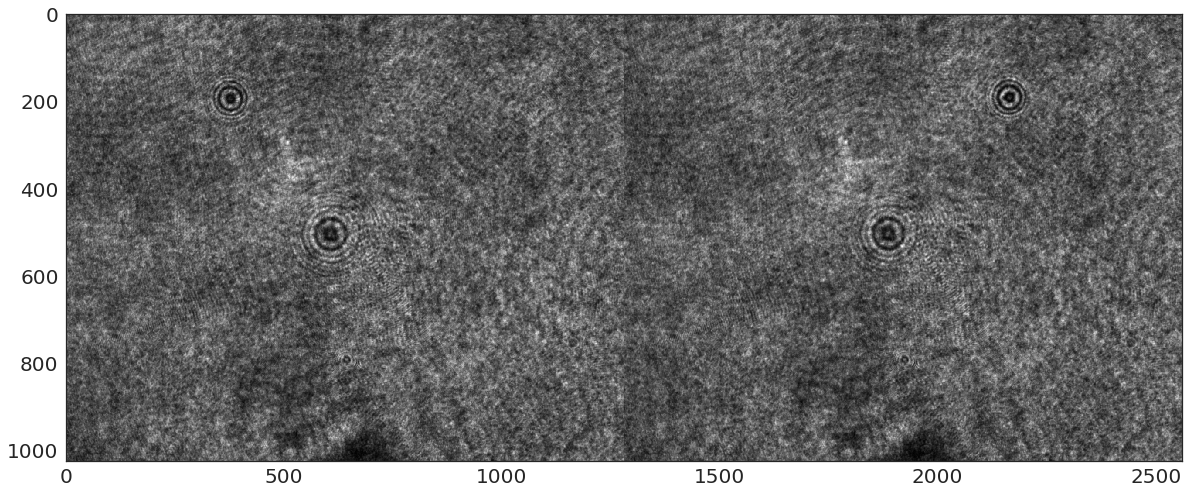

In [10]:
# Plot background next to raw frame
mega_image = np.hstack([frame, bg])
fig, ax = plt.subplots(figsize=(20,40))
ax.imshow(mega_image, cmap='gray', interpolation=None)

In [11]:
# Normalize frame
dark_count = 13
norm = (frame.astype(np.float) - dark_count) / (bg - dark_count)

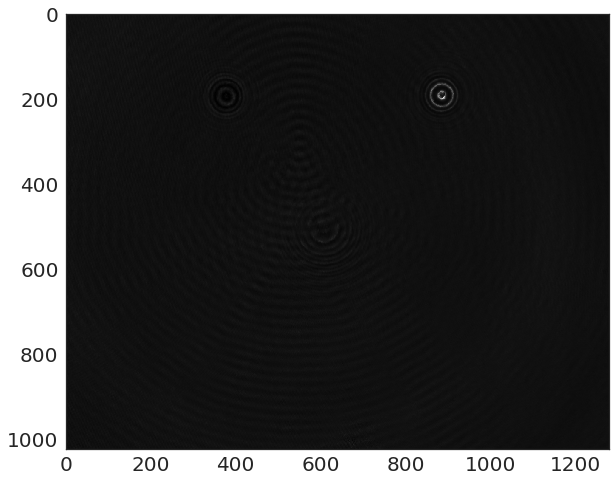

In [12]:
# Plot normalized frame
plt.imshow(norm, cmap='gray')

In [13]:
# Crop before localization to isolate the feature of interest
xc, yc = 320, 256
w, h = 640, 480
cr_norm = edit.crop(norm, xc, yc, w, h, square=False)

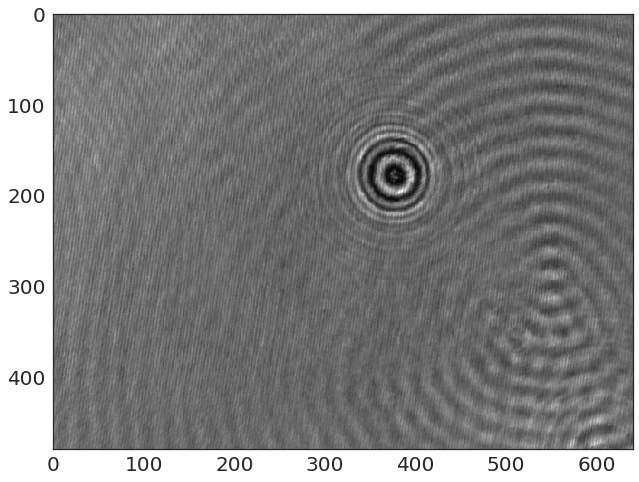

In [14]:
# Show cropped result
plt.imshow(cr_norm, cmap='gray', interpolation=None)

## Find the holographic feature.

In [15]:
# Use find features with tensorflow or oat
method = 'oat'
if method == 'oat':
    features, circle_transform = trk.oat(cr_norm, 0, feature_size=(201,201), minmass=35.0)
elif method == 'tf':
    trkr = tracker.tracker()
    features = trkr.predict((edit.inflate(cr_norm)))

Time to find 1 features at frame 0: 0.785216093063
Mass of particles: [128.37065203819407]


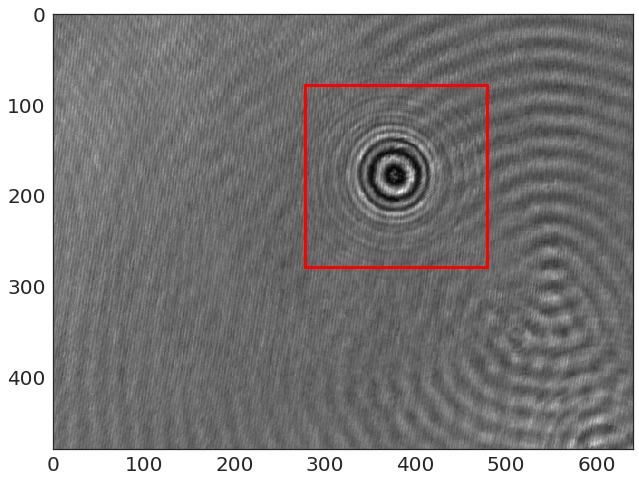

In [16]:
# Plot boxes onto circle transform
fig, ax = plt.subplots()
ax.imshow(cr_norm, cmap='gray')
for feature in features:
    x, y, w, h = feature
    test_rect = Rectangle(xy=(x - w/2, y - h/2), width=w, height=h, fill=False, linewidth=3, edgecolor='r')
    ax.add_patch(test_rect)

## Fit the frame.
1. Find the feature in the image.
2. Crop to the relevant region.
3. Use mie_fit to fit the image.

In [17]:
# Crop the frame to a reasonable size for fitting.
xc, yc, w, h = features[0]
xc, yc, w, h = int(xc), int(yc), int(w), int(h)
cropped_norm = cr_norm[yc-h//2:yc+h//2, xc-w//2:xc+w//2]

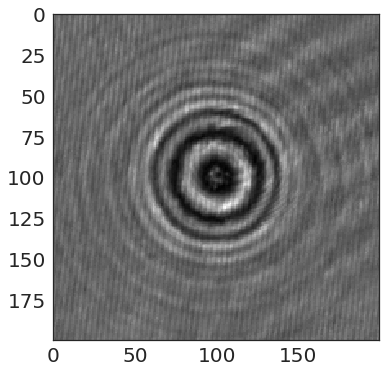

In [18]:
# Check the crop.
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(cropped_norm, cmap='gray', interpolation=None)

In [19]:
# Guess where the particle is.
guesses = [0,     # x guess [pixel]
           0,     # y guess 
           93,   # z guess
           .9,   # a_p [um]
           1.58,   # n_p [1]
           1.340,                    # n_m
           0.048,                    # mpp
           0.447]                    # lamb 

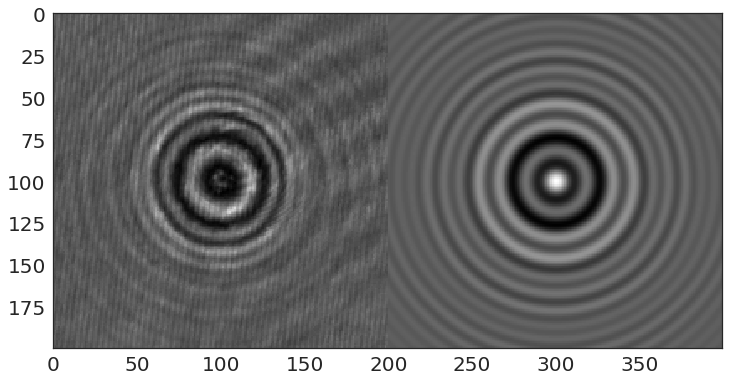

In [20]:
# Plot
x, y, z, a_p, n_p, n_m, mpp, lamb = guesses
guess = spheredhm.spheredhm([0, 0, z],
                            a_p, n_p, n_m,
                            dim=cropped_norm.shape,
                            lamb=lamb, mpp=mpp)
plt.imshow(np.hstack([cropped_norm, guess]), cmap='gray')

In [21]:
init_params = dict(zip(['x', 'y', 'z', 'a_p', 'n_p', 'n_m', 'mpp', 'lamb'], guesses))

In [22]:
mie_fit = Mie_Fitter(init_params)
result = mie_fit.fit(cropped_norm)

In [23]:
# Fit the frame to the Lorenz-Mie Theory.
result.params

Parameters([('x',
             <Parameter 'x', value=-0.37054089175220273 +/- 0.0164, bounds=[-inf:inf]>),
            ('y',
             <Parameter 'y', value=-0.7630172116374496 +/- 0.015, bounds=[-inf:inf]>),
            ('z',
             <Parameter 'z', value=90.47479427800926 +/- 0.0553, bounds=[-inf:inf]>),
            ('a_p',
             <Parameter 'a_p', value=0.9016292698062334 +/- 0.000712, bounds=[-inf:inf]>),
            ('n_p',
             <Parameter 'n_p', value=1.5993741982006329 +/- 0.00037, bounds=[-inf:inf]>),
            ('n_m', <Parameter 'n_m', value=1.34 (fixed), bounds=[-inf:inf]>),
            ('mpp', <Parameter 'mpp', value=0.048 (fixed), bounds=[-inf:inf]>),
            ('lamb',
             <Parameter 'lamb', value=0.447 (fixed), bounds=[-inf:inf]>)])

In [24]:
result.redchi

4.018871072881049

## Show the result side-by-side.

In [25]:
x, y, z, a_p, n_p, n_m, mpp, lamb = result.params.valuesdict().values()

In [26]:
fitted_image = spheredhm.spheredhm([x,y,z], a_p, n_p, n_m, lamb=lamb, dim=cropped_norm.shape, mpp=mpp)

In [27]:
residual = result.residual.reshape(*cropped_norm.shape)

Redchi: 3.9858709118623548


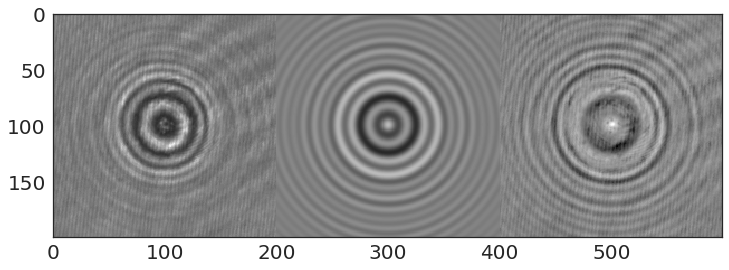

In [51]:
noise = .1
mega_image = np.hstack([cropped_norm, fitted_image, residual*noise+1.0])
fig, ax = plt.subplots(figsize=(12, 36))
ax.imshow(mega_image, cmap='gray', interpolation=None)
print("Redchi: " + str(result.redchi))